In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
from pytz import all_timezones

In [4]:
# Pandas dataframe from pandora data
npz = np.load('PandoraALTZ.npz',allow_pickle=True)
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [5]:
# Filtered data by qflag 0,10
options = [0,10] 
rslt_df = df[df['qflag'].isin(options)] 
#localization of dataframe so that datetime is UTC and not naive
dtimeutc=rslt_df.dtime.dt.tz_localize('Etc/UTC')
dtimelocal=dtimeutc.dt.tz_convert('Etc/GMT+6')
dflocal = rslt_df.assign(dtime=dtimelocal)
tslocal = dflocal.set_index('dtime')
### changing dobson units
tsloc_molcm2=tslocal.assign(ozone=tslocal.ozone*2.6868e16)
## grouping by hour
tslocmean = tsloc_molcm2.ozone.groupby(tslocal.index.hour).mean()
tslocstd=tsloc_molcm2.ozone.groupby(tslocal.index.hour).std()
## grouping by month
tslocmeanmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).mean()
tslocstdmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).std()


In [6]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
#testcount = 0
for year in years:
    merrapath = '/home/mixtli/MERRA2/'+'%i*/' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdf = pd.read_csv(filename)
        tempdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        columnO3=tempdf.modelO3.sum()
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
merradf = pd.DataFrame(data={"date": date, "ozone": O3})


In [7]:
tsmerra = merradf.set_index('date')
tsmerrameanmt = tsmerra.ozone.groupby(tsmerra.index.month).mean()
tsmerramm = tsmerra.ozone.resample('M').mean()
tsmerramm2 = tsmerramm.groupby(tsmerramm.index.month).mean()
tsmerrastdmt = tsmerra.ozone.groupby(tsmerra.index.month).std()


/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'kg/kg')

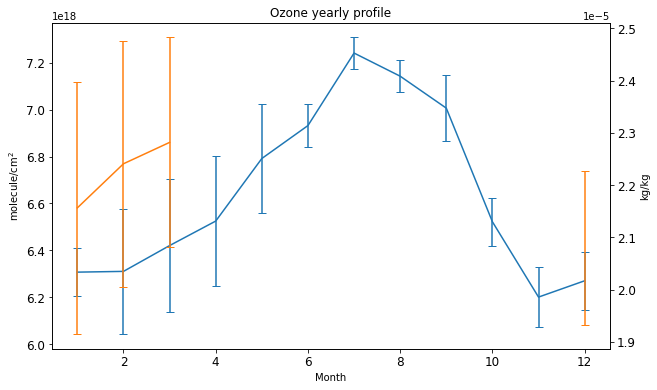

In [8]:
## simple plotting with error
ax = tslocmeanmt.plot(figsize=(10,6),title='Ozone yearly profile',ylabel='molecule/cm$^2$',yerr=tslocstdmt,capsize=4,fontsize=12)
tsmerramm2.plot(secondary_y=True,figsize=(10,6),xlabel='Month',yerr=tsmerrastdmt,capsize=4,fontsize=12)
ax.right_ax.set_ylabel('kg/kg')

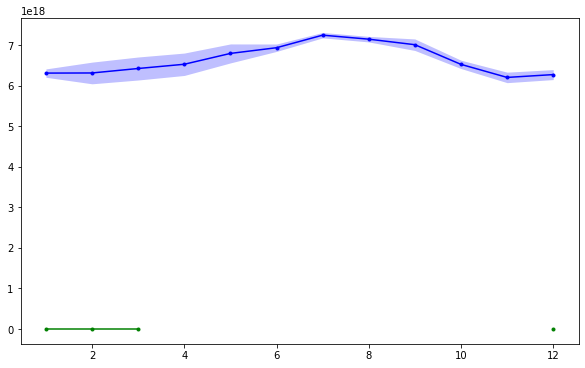

In [28]:
##pyplot plotting
x = tslocmeanmt.index
y1 = tslocmeanmt
err1 = tslocstdmt
y2 = tsmerramm2
err2 = tsmerrastdmt
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1 = plt.plot(x, y1, '.-b')
ax1 = plt.fill_between(x, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
#ax2 = ax1.twinx()
ax2 = plt.plot(x, y2, '.-g')
#ax2 = plt.fill_between(x, y2-err2, y1+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)

In [ ]:
################## TESTING AFTER THIS LINE

In [56]:
testdf = pd.read_csv(filename)
testdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
tdfa = testdf[testdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(testdf.modelP/226.32))/0.000157))
tdfb = testdf[testdf['modelP'] > 226.32].assign(modelP=((1-(testdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
testdf2=tdfa.append(tdfb)
testdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
testdf2

,fixedP,fixedO3,modelAlt,modelO3
0,43.000000,3.661876e-06,23130.502659,5.791694e-06
1,47.000000,2.999409e-06,22031.489009,4.169774e-06
2,52.275398,2.299564e-06,20945.254799,2.899628e-06
3,58.243900,1.569314e-06,19871.799326,1.811982e-06
4,65.787903,6.616212e-07,18811.109829,5.709261e-07
5,73.103401,4.618227e-07,17763.195931,3.784729e-07
6,84.512299,3.098894e-07,16728.039474,2.273772e-07
7,98.665703,1.983495e-07,15692.932467,1.559992e-07
8,114.763000,1.431719e-07,14657.782636,1.178948e-07
9,134.837006,1.193023e-07,13622.703063,1.221788e-07


In [79]:
altdiff=testdf2.modelAlt.diff()
altdiff=altdiff.replace(altdiff[0],altdiff[1])
altdiff=-altdiff
altdiff

0     1099.013650
1     1099.013650
2     1086.234210
3     1073.455473
4     1060.689496
5     1047.913898
6     1035.156458
7     1035.107006
8     1035.149832
9     1035.079573
10    1035.110545
11     991.133605
12     946.440762
13     907.274484
14     886.992238
15     595.470279
16     550.542247
17     509.177962
18     476.691444
19     447.929764
20     424.882866
21     401.825766
22     384.880427
23     367.057381
24     236.194122
25     230.318049
26     224.695020
27     218.374321
28     213.481738
29     167.412148
30     123.446577
31     121.755617
32     120.135586
33     118.666807
34     117.236215
35     115.720250
36     114.203069
37     112.887706
38     111.608897
39     110.238524
40     109.016991
41     121.413391
Name: modelAlt, dtype: float64

In [67]:
testdf2.modelO3[0]

5.791694e-06

In [82]:
testdf3 = testdf2.assign(modelO3=(testdf2.modelO3*2.69e25))
testdf3

,fixedP,fixedO3,modelAlt,modelO3
0,43.000000,3.661876e-06,23130.502659,1.557966e+20
1,47.000000,2.999409e-06,22031.489009,1.121669e+20
2,52.275398,2.299564e-06,20945.254799,7.799999e+19
3,58.243900,1.569314e-06,19871.799326,4.874232e+19
4,65.787903,6.616212e-07,18811.109829,1.535791e+19
5,73.103401,4.618227e-07,17763.195931,1.018092e+19
6,84.512299,3.098894e-07,16728.039474,6.116447e+18
7,98.665703,1.983495e-07,15692.932467,4.196378e+18
8,114.763000,1.431719e-07,14657.782636,3.171370e+18
9,134.837006,1.193023e-07,13622.703063,3.286610e+18


In [85]:
(testdf3.modelO3*(altdiff/(testdf3.modelAlt[0]-testdf3.modelAlt[41]))).sum()

2.382697112199946e+19